Data downloaded from zenodo; both data and analysis repository are needed
- https://doi.org/10.5281/zenodo.10950538
- https://doi.org/10.5281/zenodo.11050996

In [22]:
from pathlib import Path

topact_path = Path("data") / "TopACT"

topact_pub_path = topact_path / "topact-paper-1.0.0"
topact_synthetic = topact_path / "topact-data" / "syntheticdata"

outdir = Path("simulation")
result_path = Path("results")

In [2]:
outdir.mkdir(exist_ok=True, parents=True)
result_path.mkdir(exist_ok=True, parents=True)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

from sainsc import LazyKDE

In [4]:
with open(topact_pub_path / "Figure 2" / "genes.txt", "r") as f:
    genes = [l.strip() for l in f.readlines()]

In [5]:
with open(topact_synthetic / "groundtruth-labels.txt", "r") as f:
    groundtruth_labels = [l.strip() for l in f.readlines()]

In [6]:
signatures = dict()
for ct_file in (topact_pub_path / "Figure 2" / "averages").glob("*"):
    ct = ct_file.stem.split("-")[0]
    with open(ct_file, "r") as f:
        signatures[ct] = [float(l.strip()) for l in f.readlines()]

signatures = pd.DataFrame(signatures, index=genes)[groundtruth_labels]

In [7]:
from sainsc.lazykde import epanechnikov_kernel


def read_groundtruth(path):
    groundtruth = pd.read_table(path, header=None, sep=" ").to_numpy()
    return np.rint(groundtruth).astype(int)


def get_lazykde(path):
    return LazyKDE.from_dataframe(
        pd.read_csv(path, index_col=0).rename(
            columns={"geneID": "gene", "MIDCounts": "count"}
        ),
        n_threads=1,
    )


def sainsc_analysis(data_path, gt_path, out, bw, kernel="gaussian"):
    synthetic_analysis = get_lazykde(data_path)
    if kernel == "gaussian":
        synthetic_analysis.gaussian_kernel(bw)
    elif kernel == "epanechnikov":
        synthetic_analysis.kernel = epanechnikov_kernel(bw, dtype=np.float32)
    synthetic_analysis.assign_celltype(
        signatures.loc[lambda df: df.index.isin(synthetic_analysis.genes)]
    )
    groundtruth = read_groundtruth(gt_path)

    pd.DataFrame(
        {
            "assignment": synthetic_analysis.assignment_score.flatten(),
            "groundtruth": groundtruth.flatten(),
            "celltype": pd.Categorical.from_codes(
                synthetic_analysis.celltype_map.flatten(),
                categories=synthetic_analysis.celltypes,
            ),
        }
    ).to_csv(out, sep="\t", index=False)

In [8]:
out_gaussian = outdir / "gaussian"

In [9]:
out_gaussian.mkdir(exist_ok=True, parents=True)

for syn_data in (topact_synthetic / "expression").glob("*.csv"):
    experiment_id = int(syn_data.stem.split("_")[1])
    groundtruth_file = (
        topact_synthetic / "groundtruth" / f"celltypegrid_{experiment_id}.txt"
    )
    outfile = out_gaussian / f"{experiment_id}.tsv"
    sainsc_analysis(syn_data, groundtruth_file, outfile, bw=5)

In [9]:
out_epa = outdir / "epanechnikov"

In [11]:
out_epa.mkdir(exist_ok=True, parents=True)

for syn_data in (topact_synthetic / "expression").glob("*.csv"):
    experiment_id = int(syn_data.stem.split("_")[1])
    groundtruth_file = (
        topact_synthetic / "groundtruth" / f"celltypegrid_{experiment_id}.txt"
    )
    outfile = out_epa / f"{experiment_id}.tsv"
    sainsc_analysis(syn_data, groundtruth_file, outfile, bw=10, kernel="epanechnikov")

In [10]:
data_gaussian = {
    int(f.stem): pd.read_table(f).assign(
        celltype_code=lambda df: pd.Categorical(
            df["celltype"], categories=groundtruth_labels
        ).codes
    )
    for f in out_gaussian.glob("*.tsv")
}

accuracy_gaussian = {
    i: accuracy_score(df["groundtruth"], df["celltype_code"])
    for i, df in data_gaussian.items()
}

data_gaussian = (
    pd.concat(data_gaussian, names=["experiment"])
    .reset_index(level=0)
    .assign(
        classification=lambda df: pd.Categorical.from_codes(
            (df["groundtruth"] == df["celltype_code"]).astype(int),
            categories=["misclassified", "correct"],
        )
    )
)

In [35]:
data_gaussian[["experiment", "celltype", "assignment", "classification"]].rename(
    columns={"experiment": "Simulation ID", "assignment": "Assignment score"}
).sort_values(["Simulation ID", "celltype"]).to_csv(
    result_path / "Classification_and_AssignmentScore_per_celltype.tsv",
    sep="\t",
    index=False,
    float_format="%.5f",
)

In [11]:
data_epa = {
    int(f.stem): pd.read_table(f).assign(
        celltype_code=lambda df: pd.Categorical(
            df["celltype"], categories=groundtruth_labels
        ).codes
    )
    for f in out_epa.glob("*.tsv")
}

accuracy_epa = {
    i: accuracy_score(df["groundtruth"], df["celltype_code"])
    for i, df in data_epa.items()
}

In [12]:
import itertools

# adapted from the published code Figure 2/Accuracy.ipynb from the TopACT publication

# fmt: off
ACTUAL_CELLTYPES = ['PT', 'TAL', 'DCT', 'ENDO', 'VSM', 'CCD', 'IMMUNE', 'PODS', 'UROTHELIUM']
ALPHABETICAL_CELLTYPES = ['CCD', 'DCT', 'ENDO', 'IMMUNE', 'PODS', 'PT', 'TAL', 'UROTHELIUM', 'VSM']
# fmt: on

topact_accuracy = dict()
topact_accuracy_filtered = dict()
rctd_accuracy = dict()
for i in range(100):
    # Ground truth cell types
    actual = np.loadtxt(topact_synthetic / "groundtruth" / f"celltypegrid_{i}.txt")

    # TOPACT PREDICTIONS

    # Convert indices to match order of ground truth cell types
    def convert_topact(image):
        def convert_coord(p):
            x = image[p]
            if np.isnan(x):
                return -1  # Represents missing prediction
            return ACTUAL_CELLTYPES.index(ALPHABETICAL_CELLTYPES[int(x)])

        return np.array(
            list(map(convert_coord, itertools.product(range(500), range(500))))
        ).reshape((500, 500))

    # TopACT confidence matrix
    predicted = np.loadtxt(topact_synthetic / "topactpreds" / f"topactpreds_{i}.txt")
    # Convert to ground truth cell type indices
    predicted = convert_topact(predicted)

    # This is the accuracy of the underlying prediction
    topact_accuracy[i] = len(np.where(predicted == actual)[0]) / predicted.size
    actual_flat = actual.flatten()
    predicted = predicted.flatten()
    remove_unassigned = predicted != [-1]
    predicted = predicted[remove_unassigned]
    actual_flat = actual_flat[remove_unassigned]
    topact_accuracy_filtered[i] = (
        len(np.where(predicted == actual_flat)[0]) / predicted.size
    )

    rctd = pd.read_csv(topact_synthetic / "rctdoutput" / f"rctd_{i}.csv")

    rctd.rename(columns={rctd.columns[0]: "spot"}, inplace=True)

    # Extract cell cords from RCTD output array
    rctd["x"] = list(map(lambda x: int(x[4:].split(".")[0]), rctd["spot"]))
    rctd["y"] = list(map(lambda x: int(x[4:].split(".")[1]), rctd["spot"]))
    rctdarr = np.zeros((500, 500)).astype("int") - 1  # -1 represents missing prediction
    for row in rctd.itertuples():
        # For each predicted cell type, assign prediction to whole bin
        # WARNING: in SciPy >= 1.11.0 this will need to be changed as the mode function is being updated
        rctdarr[
            row.x * 20 : row.x * 20 + 20, row.y * 20 : row.y * 20 + 20
        ] = ACTUAL_CELLTYPES.index(row.first_type)

    rctd_accuracy[i] = len(np.where(rctdarr == actual)[0]) / rctdarr.size

In [13]:
accuracy_df = pd.concat(
    [
        pd.Series(data, name="Accuracy").to_frame().reset_index().assign(Tool=name)
        for name, data in {
            "sainsc\n(gaussian)": accuracy_gaussian,
            "sainsc\n(epanechnikov)": accuracy_epa,
            "TopACT": topact_accuracy,
            "RCTD": rctd_accuracy,
        }.items()
    ]
).rename(columns={"index": "id"})

In [23]:
accuracy_df.rename(columns={"id": "Simulation ID", "tool": "Tool"}).loc[
    :, ["Simulation ID", "Tool", "Accuracy"]
].assign(Tool=lambda df: df["Tool"].str.replace("\n", " ")).sort_values(
    ["Simulation ID", "Tool"]
).to_csv(
    result_path / "Accuracy_comparison.tsv", sep="\t", index=False, float_format="%.3f"
)

In [24]:
def accuracy_per_quantile(ct, df, quantile=0.05, steps=11):
    records = []
    for i in range(steps):
        pixels = df.shape[0]
        threshold = df["assignment"].quantile(quantile * i)
        df = df.loc[df["assignment"] >= threshold]
        acc = accuracy_score(df["groundtruth"], df["celltype_code"])
        records.append(
            {
                "celltype": ct,
                "quantile": quantile * i,
                "accuracy": acc,
                "assigned_pixels": df.shape[0] / pixels,
            }
        )
    return records


records = []
for ct, df in data_gaussian.loc[lambda df: df["experiment"] == 0].groupby("celltype"):
    records.extend(accuracy_per_quantile(ct, df))

records.extend(accuracy_per_quantile("all", data_gaussian))

In [25]:
records = pd.DataFrame(records)

In [26]:
records.loc[lambda df: df["quantile"] == 0.50]

,celltype,quantile,accuracy,assigned_pixels
10,CCD,0.5,0.997384,0.500000
21,DCT,0.5,1.000000,0.500181
32,ENDO,0.5,1.000000,0.500000
43,IMMUNE,0.5,0.894928,0.500000
54,PODS,0.5,1.000000,0.500000
65,PT,0.5,0.995856,0.500000
76,TAL,0.5,0.999228,0.500193
87,UROTHELIUM,0.5,1.000000,0.500000
98,VSM,0.5,1.000000,0.500855
109,all,0.5,0.992439,0.500000


In [28]:
records.drop(columns=["assigned_pixels"]).to_csv(
    result_path / "Accuracy_per_celltype.tsv",
    sep="\t",
    index=False,
    float_format="%.3f",
)

In [29]:
# fmt: off
ACTUAL_CELLTYPES = ['PT', 'TAL', 'DCT', 'ENDO', 'VSM', 'CCD', 'IMMUNE', 'PODS', 'UROTHELIUM']
ACTUAL_COLOURS = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
# fmt: on

cmap = dict(zip(ACTUAL_CELLTYPES, ACTUAL_COLOURS))

In [30]:
synthetic_analysis = get_lazykde(topact_synthetic / "expression" / "reads_0.csv")
synthetic_analysis.gaussian_kernel(5)
synthetic_analysis.assign_celltype(
    signatures.loc[lambda df: df.index.isin(synthetic_analysis.genes)]
)

In [19]:
as_per_celltype = pd.DataFrame(
    {
        "as": synthetic_analysis.assignment_score.flatten(),
        "celltype": pd.Categorical.from_codes(
            synthetic_analysis.celltype_map.ravel(),
            categories=synthetic_analysis.celltypes,
        ),
    }
)

celltype_threshold = (
    (as_per_celltype.groupby("celltype", observed=True).quantile(0.2))
    .loc[:, "as"]
    .to_dict()
)

synthetic_analysis.calculate_total_mRNA_KDE()
synthetic_analysis.filter_background(0, min_assignment=celltype_threshold)

In [20]:
filtered = synthetic_analysis.celltype_map + 1
filtered[synthetic_analysis.background] = 0

In [21]:
groundtruth = np.loadtxt(topact_synthetic / "groundtruth" / "celltypegrid_0.txt")

/tmp/ipykernel_4133842/2862568246.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_4133842/2862568246.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


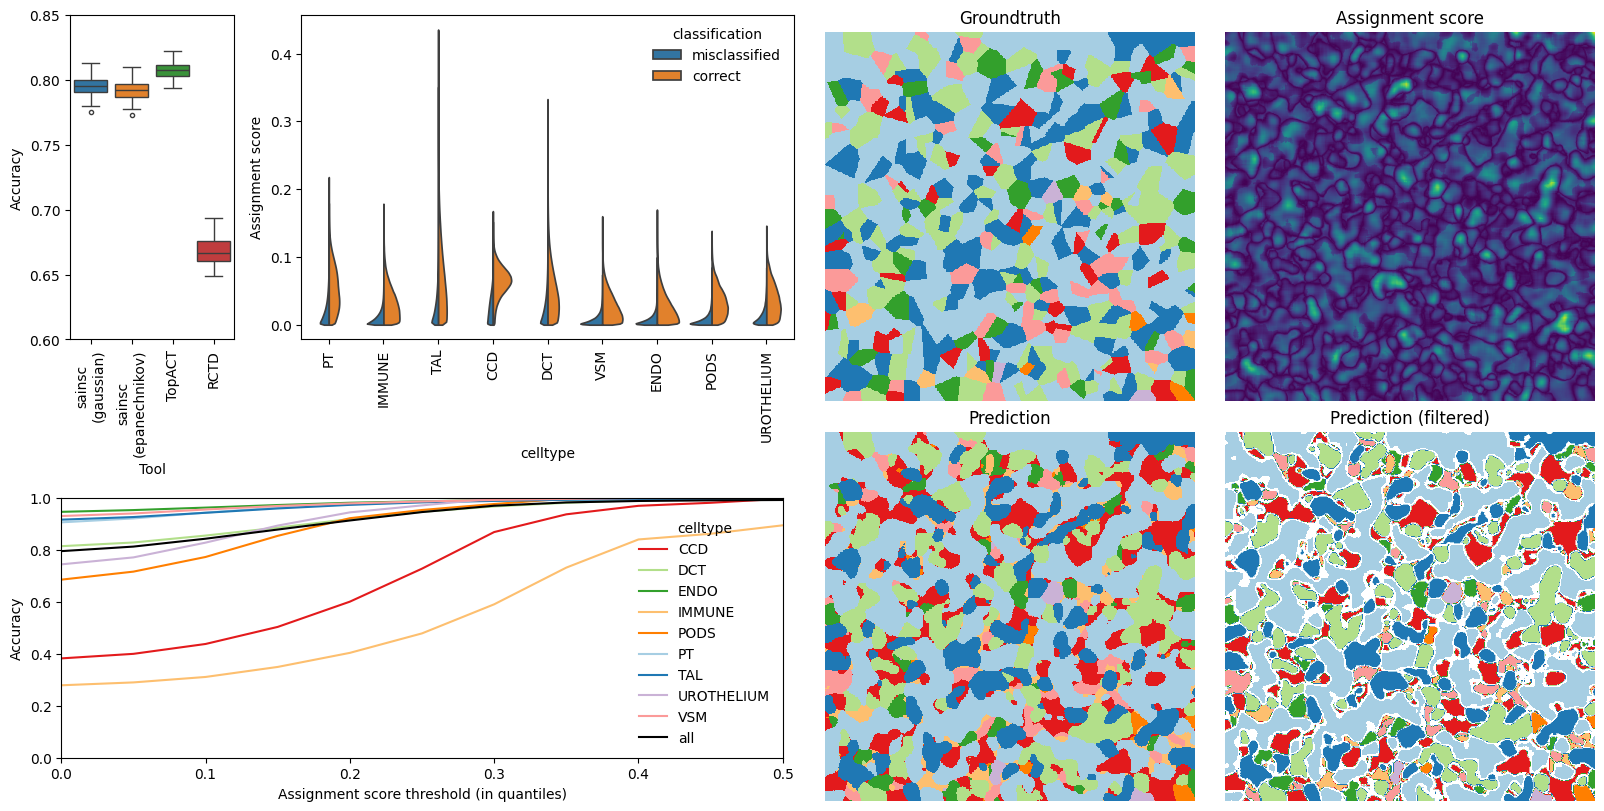

In [24]:
fig = plt.figure(layout="constrained", figsize=(16, 8))

left_right = fig.subfigures(1, 2, width_ratios=[1, 1])

left_part = left_right[0].subfigures(2, 1, height_ratios=[1.5, 1])


axs = left_part[0].subplots(1, 2, width_ratios=[1, 3])
_ = sns.boxplot(
    data=accuracy_df,
    x="Tool",
    y="Accuracy",
    hue="Tool",
    flierprops={"marker": "."},
    ax=axs[0],
)
_ = axs[0].set(ylim=(0.6, 0.85))
_ = axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.violinplot(
    data=data_gaussian,
    y="assignment",
    x="celltype",
    hue="classification",
    split=True,
    cut=0,
    inner=None,
)
_ = axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
_ = axs[1].legend_.get_frame().set_alpha(0)
_ = axs[1].set(ylabel="Assignment score")

ax = left_part[1].subplots()

ax = sns.lineplot(
    data=records,
    x="quantile",
    y="accuracy",
    hue="celltype",
    palette=cmap | {"all": "black"},
)
_ = ax.legend_.get_frame().set_alpha(0)
_ = ax.set(
    xlabel="Assignment score threshold (in quantiles)",
    ylabel="Accuracy",
    xlim=(0, 0.5),
    ylim=(0, 1),
)

axs = left_right[1].subplots(2, 2)

axs[0, 0].imshow(
    groundtruth.T,
    cmap=ListedColormap(cmap.values()),
    origin="lower",
    interpolation="none",
)

axs[1, 0].imshow(
    synthetic_analysis.celltype_map.T,
    cmap=ListedColormap(cmap.values()),
    origin="lower",
    interpolation="none",
)

axs[0, 1].imshow(synthetic_analysis.assignment_score.T, origin="lower")

axs[1, 1].imshow(
    filtered.T, cmap=ListedColormap(["white"] + list(cmap.values())), origin="lower"
)

axs[0, 0].set(title="Groundtruth")
axs[1, 0].set(title="Prediction")
axs[0, 1].set(title="Assignment score")
axs[1, 1].set(title="Prediction (filtered)")

axs[0, 0].set_axis_off()
axs[1, 0].set_axis_off()
axs[0, 1].set_axis_off()
axs[1, 1].set_axis_off()

# fig.tight_layout()

In [25]:
fig.savefig("figures/Fig2.pdf")

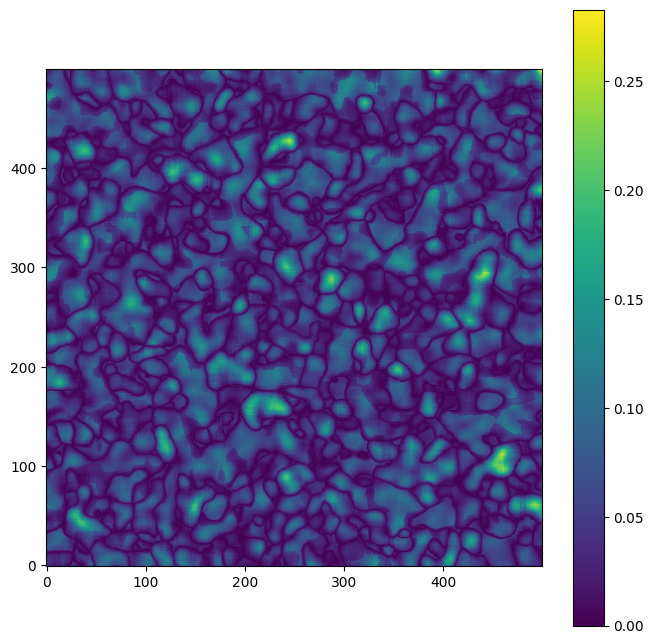

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(synthetic_analysis.assignment_score.T, origin="lower")
fig.colorbar(im, ax=ax)

In [24]:
fig.savefig("figures/Fig2_scales.pdf")